In [1]:
import os, sys, glob
import logging
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt

import numba

import signal_generator
from signal_generator import SignalGenerator
from background_generator import BackgroundGenerator
from utils import bin_to_healpix

In [2]:
public_data_directory = "../gxn/gXn_simulations/icecube_10year_ps/"

aeffs = sorted(glob.glob(os.path.join(public_data_directory, "irfs/IC86_II_effectiveArea.csv")))
smearing = sorted(glob.glob(os.path.join(public_data_directory, "irfs/IC86_II_smearing.csv")))
uptime = [os.path.join(public_data_directory, "uptime/IC86_II_exp.csv"),
          os.path.join(public_data_directory, "uptime/IC86_III_exp.csv"),
          os.path.join(public_data_directory, "uptime/IC86_IV_exp.csv"),
          os.path.join(public_data_directory, "uptime/IC86_V_exp.csv"),
          os.path.join(public_data_directory, "uptime/IC86_VI_exp.csv"),
          os.path.join(public_data_directory, "uptime/IC86_VII_exp.csv")]
data = [os.path.join(public_data_directory, "events/IC86_II_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_III_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_IV_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_V_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_VI_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_VII_exp.csv")]

x = SignalGenerator(aeffs, smearing, uptime,
                    angular_resolution_scale=1.0)
y = BackgroundGenerator(data)


/data/condor_builds/users/mlarson/public_data_trials/signal_generator.py:91: RuntimeWarning: divide by zero encountered in log
  - np.cos(np.radians(smearing['AngErr_max[deg]'])))))


Text(0,0.5,'sin($\\delta$)')

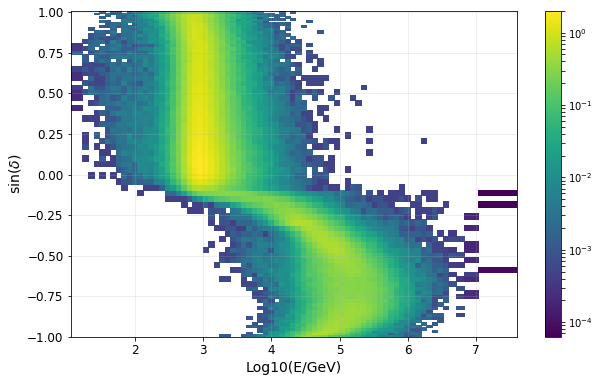

In [3]:
fig, ax = plt.subplots(figsize=(10,6))
cmesh = ax.pcolormesh(y.loge_bins, y.sindec_bins, y.pdf_histogram.T,
                      norm=LogNorm())
plt.colorbar(cmesh, ax=ax)

ax.grid(alpha=0.25)
ax.tick_params(labelsize=12)
ax.set_xlabel(r"Log10(E/GeV)", fontsize=14)
ax.set_ylabel(r"sin($\delta$)", fontsize=14)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


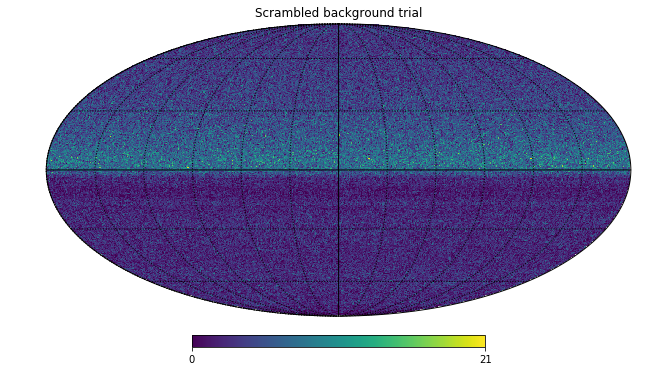

In [4]:
bg_events = y.scramble()
event_map = bin_to_healpix(128, np.degrees(bg_events['ra']), np.degrees(bg_events['dec']))
hp.mollview(event_map, flip='geo', title='Scrambled background trial')
hp.graticule(coord='E',)

In [6]:
def sob(events, new=False):
    S = x.pdf_pointsource(events,
                          declination_deg = dec_deg, 
                          right_ascension_deg = ra_deg,
                          integral_flux_function = powerlaw_integral_flux)
    Snllh = np.log(S)
    Bnllh = y.logpdf(events['logE'], np.sin(events['dec'])) - np.log(2*np.pi) 
    logsob = Snllh-Bnllh
    return logsob

def trim(events, angle=10):
    query_string = (f"(({np.radians(dec_deg-angle)} < dec < {np.radians(dec_deg+angle)})"
                    f" & ({np.radians(ra_deg-angle)} < ra < {np.radians(ra_deg+angle)}))")
    return events.query(query_string)


In [7]:
def powerlaw_integral_flux(emin, emax, normalization=1e-13, E0=1000, index=-2):
    if index > 0:
        logging.error("Please give a spectral index below 0")
        sys.exit(1)

    integral = normalization/E0**index
    if index == -1:  integral *= np.log(emax/emin)
    elif index != -1:
        integral *= (emax**(1+index) - emin**(1+index))/(1+index)
    return integral

dec_deg, ra_deg = 20, 10
signal = x.generate_pointsource(declination_deg = dec_deg, 
                                right_ascension_deg = ra_deg,
                                integral_flux_function = powerlaw_integral_flux)
background = y.scramble()

new = False
signal = trim(signal)
background = trim(background)

signal_sob = sob(signal)
background_sob = sob(background)

/data/condor_builds/users/mlarson/public_data_trials/signal_generator.py:39: RuntimeWarning: divide by zero encountered in log
  return np.log(output)
/data/i3home/mjlarson/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/data/condor_builds/users/mlarson/public_data_trials/background_generator.py:80: RuntimeWarning: divide by zero encountered in log
  return np.log(self.pdf(loge, sindec))


1027 1076
9863 9863


Text(0.5,0,'log(S/B)')

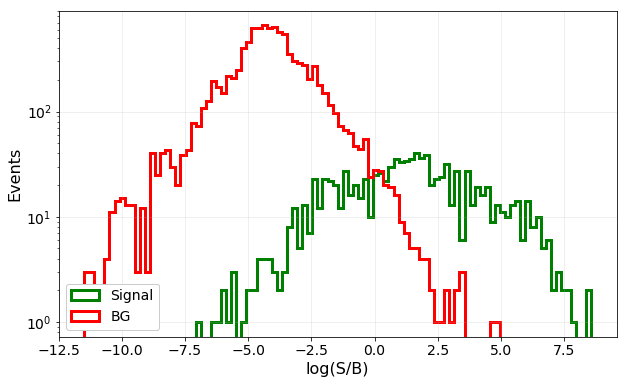

In [8]:
llh_bins = 100#np.linspace(-5, 10, 20)
fig, ax = plt.subplots(figsize=(10,6))

print(np.isfinite(signal_sob).sum(), len(signal_sob))
print(np.isfinite(background_sob).sum(), len(background_sob))

r = np.concatenate([background_sob[np.isfinite(background_sob)],
                    signal_sob[np.isfinite(signal_sob)]])

ax.hist(signal_sob,
        bins=llh_bins,
        range=[r.min(), r.max()],
        histtype='step',
        linewidth=3,
        color='g',
        label="Signal")
ax.hist(background_sob,
        bins=llh_bins,
        range=[r.min(), r.max()],
        histtype='step', 
        linewidth=3,
        color='r',
        label='BG')

ax.grid(alpha=0.25)
ax.legend(loc='lower left', fontsize=14, framealpha=1)
ax.tick_params(labelsize=14)
ax.set_yscale('log')
ax.set_ylabel("Events", fontsize=16)
ax.set_xlabel("log(S/B)", fontsize=16)



In [8]:
%timeit sob(background)

/data/i3home/mjlarson/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


45.2 ms ± 889 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Text(0,0.5,'Declination (Deg)')

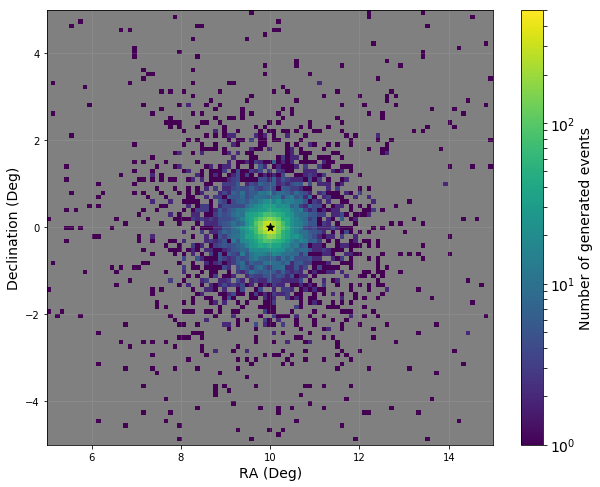

In [11]:
def powerlaw_integral_flux(emin, emax, normalization=1e-12, E0=1000, index=-2):
    if index > 0:
        logging.error("Please give a spectral index below 0")
        sys.exit(1)

    integral = normalization/E0**index
    if index == -1:  integral *= np.log(emax/emin)
    elif index != -1:
        integral *= (emax**(1+index) - emin**(1+index))/(1+index)
    return integral

# Produce some events from the point source
dec_deg, ra_deg = 0, 10
events = x.generate_pointsource(declination_deg = dec_deg, 
                                right_ascension_deg = ra_deg,
                                integral_flux_function = powerlaw_integral_flux)


# Plot the events
fig, ax = plt.subplots(figsize=(10, 8))
_ = ax.scatter(ra_deg, dec_deg, 
               color='k', 
               marker='*',
               s=64,
               label='Source',
               zorder=100)

ra_bins = np.linspace(ra_deg-5, ra_deg+5, 100)
delta_dec = np.max(np.abs(dec_deg-np.degrees(events['dec'])))
dec_bins = np.linspace(dec_deg-5, dec_deg+5, 100)

h, _, _ = np.histogram2d(np.degrees(events['ra']),
                         np.degrees(events['dec']),
                         bins=(ra_bins, dec_bins))
cmesh = ax.pcolormesh(ra_bins, dec_bins, h.T,
                      norm=LogNorm()
                      )
cbar = plt.colorbar(cmesh, ax=ax)
cbar.ax.set_ylabel('Number of generated events', fontsize=14)
cbar.ax.tick_params(labelsize=14)

ax.grid(alpha=0.25)
ax.set_xlim(ra_bins.min(), ra_bins.max())
ax.set_ylim(dec_bins.min(), dec_bins.max())
ax.set_xlabel("RA (Deg)", fontsize=14)
ax.set_ylabel(r"Declination (Deg)", fontsize=14)

In [12]:
%%timeit 
x.generate_pointsource(declination_deg=0, 
                       right_ascension_deg=10,
                       integral_flux_function = powerlaw_integral_flux)

23.7 ms ± 142 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


/data/condor_builds/users/mlarson/public_data_trials/signal_generator.py:134: RuntimeWarning: invalid value encountered in arcsin
  reco_dec = np.arcsin(reco_unit[2])


Text(0,0.5,'Number of astrophysical signal events/bin')

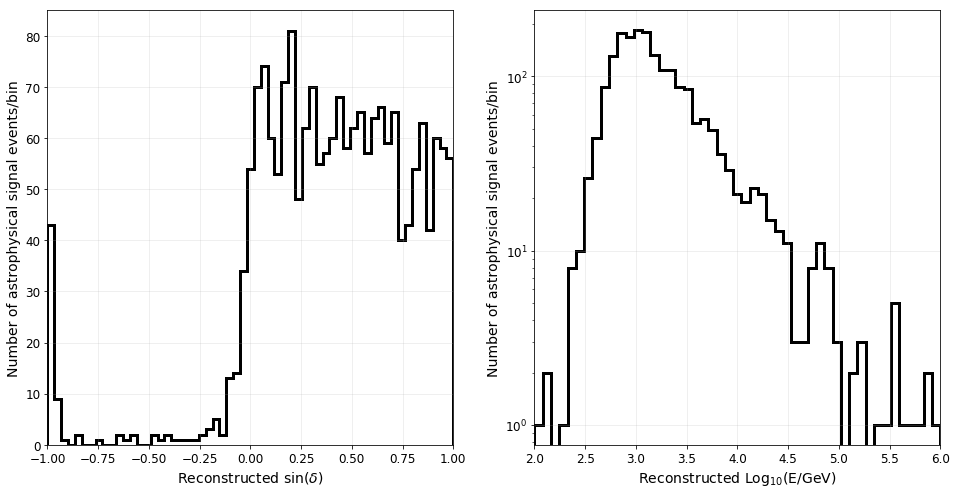

In [13]:
def powerlaw_integral_flux(emin, emax, normalization=1.36e-18, E0=1e5, index=-2.37):
    if index > 0:
        logging.error("Please give a spectral index below 0")
        sys.exit(1)

    integral = normalization/E0**index    
    if index == -1:  integral *= np.log(emax/emin)
    elif index != -1:
        integral *= (emax**(1+index) - emin**(1+index))/(1+index)
    
    return integral

# Generate the events
events = x.generate_diffuse(integral_flux_function = powerlaw_integral_flux)

# Plot the events
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
sindec_bins = np.linspace(-1, 1, 60)
_ = ax1.hist(np.sin(events['dec'].values),
            bins = sindec_bins,
            histtype='step',
            linewidth=3,
            color='k')

loge_bins = np.linspace(2, 6, 50)
_ = ax2.hist(events['logE'].values,
            bins = loge_bins,
            histtype='step',
            linewidth=3,
            color='k')

ax1.grid(alpha=0.25)
ax1.tick_params(labelsize=12)
ax1.set_xlim(sindec_bins.min(), sindec_bins.max())
ax1.set_xlabel(r"Reconstructed sin($\delta$)", fontsize=14)
ax1.set_ylabel(r"Number of astrophysical signal events/bin", fontsize=14)

ax2.grid(alpha=0.25)
ax2.tick_params(labelsize=12)
ax2.set_xlim(loge_bins.min(), loge_bins.max())
ax2.set_yscale('log')
ax2.set_xlabel(r"Reconstructed Log$_{10}$(E/GeV)", fontsize=14)
ax2.set_ylabel(r"Number of astrophysical signal events/bin", fontsize=14)

In [ ]:
mc = np.load("/data/i3store/users/mjlarson/ps_tracks/version-003-p02/IC86_2012_MC.npy")

# Plot the events
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
sindec_bins = np.linspace(-1, 1, 60)
_ = ax1.hist(np.sin(mc['dec']),
            bins = sindec_bins,
             weights=mc['ow'] * 1.36e-18*(mc['trueE']/1e5)**(-2.37) * x.total_uptime*24*3600,
            histtype='step',
            linewidth=3,
             label = 'Internal MC',
            color='k')

loge_bins = np.linspace(2, 6, 50)
_ = ax2.hist(mc['logE'],
            bins = loge_bins,
             weights=mc['ow'] * 1.36e-18*(mc['trueE']/1e5)**(-2.37) * x.total_uptime*24*3600,
            histtype='step',
            linewidth=3,
             label = 'Internal MC',
            color='k')

_ = ax1.hist(np.sin(events['dec'].values),
            bins = sindec_bins,
            histtype='step',
             label = 'Sampler code',
            linewidth=3,
            color='b')

_ = ax2.hist(events['logE'].values,
            bins = loge_bins,
            histtype='step',
             label = 'Sampler code',
            linewidth=3,
            color='b')

ax1.legend(loc='upper left', fontsize=14)
ax1.grid(alpha=0.25)
ax1.tick_params(labelsize=12)
ax1.set_xlim(sindec_bins.min(), sindec_bins.max())
ax1.set_xlabel(r"Reconstructed sin($\delta$)", fontsize=14)
ax1.set_ylabel(r"Number of astrophysical signal events/bin", fontsize=14)

ax2.grid(alpha=0.25)
ax2.tick_params(labelsize=12)
ax2.set_xlim(loge_bins.min(), loge_bins.max())
ax2.set_yscale('log')
ax2.set_xlabel(r"Reconstructed Log$_{10}$(E/GeV)", fontsize=14)
ax2.set_ylabel(r"Number of astrophysical signal events/bin", fontsize=14)


Text(0,0.5,'Number of astrophysical signal events/bin')

In [18]:
x = SignalGenerator(aeffs, smearing, uptime,
                    angular_resolution_scale=1.0)

/data/condor_builds/users/mlarson/public_data_trials/signal_generator.py:77: RuntimeWarning: divide by zero encountered in log
  - np.cos(np.radians(smearing['AngErr_max[deg]'])))))


template nside: 128
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


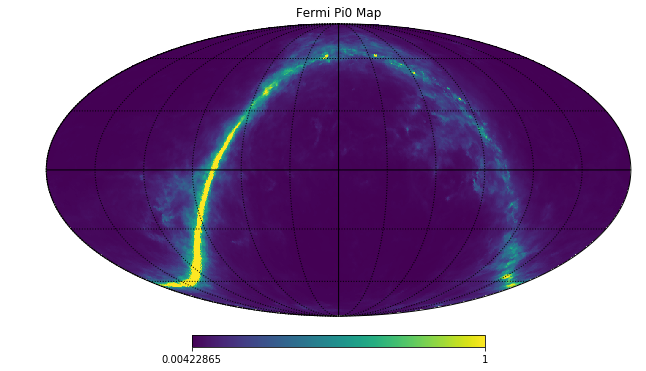

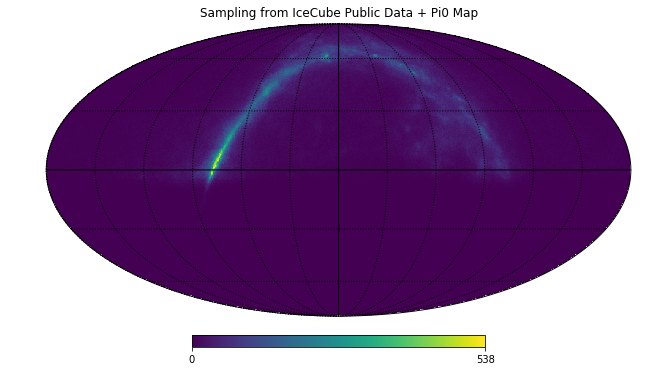

In [19]:
def pi0_powerlaw_integral_flux(map_value, emin, emax, 
                               normalization=4.43e-19, E0=1e5, index=-2.7):
    if index > 0:
        logging.error("Please give a spectral index below 0")
        sys.exit(1)

    integral = map_value * normalization/E0**index
    if index == -1:  integral *= np.log(emax/emin)
    elif index != -1:
        integral *= (emax**(1+index) - emin**(1+index))/(1+index)
    return integral

# Load a healpix map for testing
pi0_template = np.load("./template.npy")
print('template nside:', hp.npix2nside(len(pi0_template)))
hp.mollview(pi0_template, max=1, flip='geo', title='Fermi Pi0 Map')
hp.graticule(coord='E',)

# Generate events from it and plot them
events = x.generate_from_healpix(pi0_template, pi0_powerlaw_integral_flux)
event_map = bin_to_healpix(128, np.degrees(events['ra']), np.degrees(events['dec']))
hp.mollview(event_map, flip='geo', title='Sampling from IceCube Public Data + Pi0 Map')
hp.graticule(coord='E',)


In [20]:
%timeit x.generate_from_healpix(pi0_template, pi0_powerlaw_integral_flux)

9.66 s ± 25.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/data/condor_builds/users/mlarson/public_data_trials/signal_generator.py:118: RuntimeWarning: invalid value encountered in log
  - np.cos(np.radians(smearing['PSF_max[deg]'])))))
/data/condor_builds/users/mlarson/public_data_trials/signal_generator.py:118: RuntimeWarning: invalid value encountered in logaddexp
  - np.cos(np.radians(smearing['PSF_max[deg]'])))))


template nside: 128
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


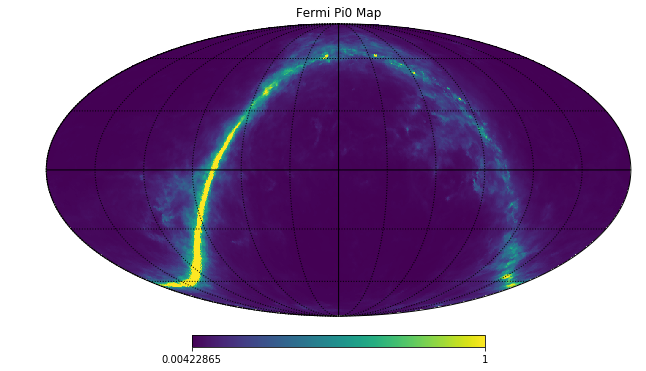

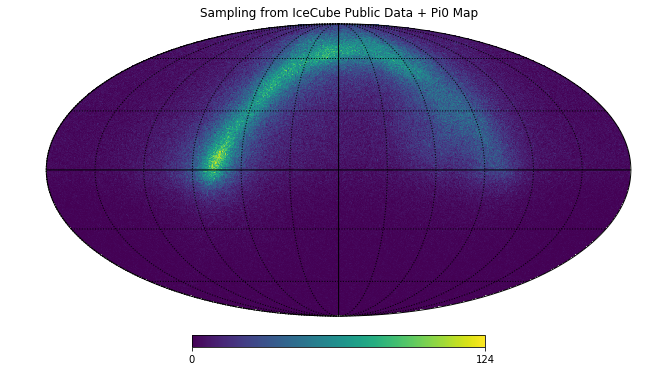

In [19]:
# Test for cascade-like event angular resolutions...
x2 = SignalGenerator(aeffs, smearing, uptime,
                    angular_resolution_scale=15.0)

def pi0_powerlaw_integral_flux(map_value, emin, emax, 
                               normalization=4.43e-19, E0=1e5, index=-2.7):
    if index > 0:
        logging.error("Please give a spectral index below 0")
        sys.exit(1)

    integral = map_value * normalization/E0**index
    if index == -1:  integral *= np.log(emax/emin)
    elif index != -1:
        integral *= (emax**(1+index) - emin**(1+index))/(1+index)
    return integral

# Load a healpix map for testing
pi0_template = np.load("./template.npy")
print('template nside:', hp.npix2nside(len(pi0_template)))
hp.mollview(pi0_template, max=1, flip='geo', title='Fermi Pi0 Map')
hp.graticule(coord='E',)

# Generate events from it and plot them
events = x2.generate_from_healpix(pi0_template, pi0_powerlaw_integral_flux)
event_map = bin_to_healpix(128, np.degrees(events['ra']), np.degrees(events['dec']))
hp.mollview(event_map, flip='geo', title='Sampling from IceCube Public Data + Pi0 Map')
hp.graticule(coord='E',)


In [3]:
import astropy.io.fits as pf
source_file = "/data/condor_builds/users/mlarson/gxn/gXn_simulations/gXn_positivetest/datafiles/catalog_sim12_input.fits"
sources = pf.open(source_file)[1].data

print(len(sources))
print(np.random.choice(sources))
print(sources.dtype)

84989
(b'Blazar_81116', b'SmoothBrokenPowerLaw', 10.14685345, -6.78716755, 115.22138977, -69.496315, 2465., 1.388e-15, 1.7, 2.8)
(numpy.record, [('Source_Name', 'S48'), ('SpectrumType', 'S48'), ('RAJ2000', '>f8'), ('DECJ2000', '>f8'), ('GLON', '>f8'), ('GLAT', '>f8'), ('ebreak', '>f8'), ('prefactor', '>f8'), ('index1', '>f8'), ('index2', '>f8')])


In [4]:
def powerlaw_integral_flux(emin, emax, normalization=1e-12, E0=1000, index=-2):
    if index > 0:
        logging.error("Please give a spectral index below 0")
        sys.exit(1)

    integral = normalization/E0**index
    if index == -1:  integral *= np.log(emax/emin)
    elif index != -1:
        integral *= (emax**(1+index) - emin**(1+index))/(1+index)
    return integral

def brokenpowerlaw(E, A, Eb, gamma1, gamma2):
    return A/((E/Eb)**gamma1 + (E/Eb)**gamma2)

#@numba.njit
def integral_brokenpowerlaw(Emin, Emax, A, Eb, gamma1, gamma2):
    fluxmin = brokenpowerlaw(Emin, A, Eb, gamma1, gamma2)
    fluxmax = brokenpowerlaw(Emax, A, Eb, gamma1, gamma2)
    return (fluxmin+fluxmax)/2 * (Emax-Emin)

def produce_one():
    source = np.random.choice(sources)
    
    # Produce some events from the point source
    flux = lambda Emin, Emax: integral_brokenpowerlaw(Emin, Emax, 
                                                      source['prefactor'], 
                                                      source['ebreak'],
                                                      source['index1'],
                                                      source['index2'])
    events = x.get_expectations(declination_deg = source['DECJ2000'], 
                                    right_ascension_deg = source['RAJ2000'],
                                    integral_flux_function = flux)
    return events
    #print(source, events[1].sum(), end=', ')
    #events = x.generate_pointsource(declination_deg = source['DECJ2000'], 
    #                                right_ascension_deg = source['RAJ2000'],
    #                                integral_flux_function = flux)
    #print(len(events))
    #return events

    

a, b = produce_one()

In [5]:
%timeit produce_one()

68.6 ms ± 595 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
print(sources[0])

('Blazar_1', 'SmoothBrokenPowerLaw', 218.9278564453125, -15.324108123779297, 336.85174560546875, 40.58078384399414, 28400.0, 1.3349999999999999e-17, 1.7, 2.8)


[1.02e+00 1.60e-01 7.70e-02 1.54e-01 2.30e-02 9.10e-02 4.00e-02 1.40e-02
 2.20e-02 1.90e-02 2.10e-02 7.70e-02 7.00e-03 7.00e-02 1.50e-02 6.00e-03
 6.00e-03 1.20e-02 9.00e-03 2.80e-02 8.00e-03 2.50e-02 1.00e-03 2.00e-02
 9.00e-03 1.40e-02 2.00e-03 7.00e-03 4.30e-02 1.60e-02 9.00e-03 4.10e-02
 6.00e-03 2.30e-02 1.00e-03 6.00e-03 4.00e-03 2.50e-02 1.90e-02 2.90e-02
 4.00e-03 3.00e-03 5.00e-03 2.90e-02 7.00e-03 7.00e-03 2.10e-02 9.00e-03
 2.20e-02 1.30e-02 8.00e-03 2.50e-02 5.00e-03 1.10e-02 1.00e-03 1.60e-02
 4.00e-03 8.00e-03 4.00e-03 1.60e-02 1.20e-02 6.00e-03 2.20e-02 3.00e-03
 1.70e-02 1.40e-02 5.00e-03 3.40e-02 2.20e-02 1.10e-02 2.00e-02 8.00e-03
 2.20e-02 5.00e-03 3.40e-02 8.00e-03 3.00e-03 3.00e-03 2.00e-03 2.00e-03
 6.00e-03 2.00e-03 8.00e-03 2.20e-02 2.60e-02 2.50e-02 1.00e-02 1.20e-02
 4.00e-02 3.50e-02 6.00e-03 1.00e-02 4.00e-03 2.40e-02 9.00e-03 1.00e-03
 6.00e-03 4.30e-02 8.00e-03 4.00e-03 4.00e-03 3.00e-03 7.70e-02 1.10e-02
 1.20e-02 2.20e-02 1.20e-02 3.90e-02 5.00e-03 6.00e

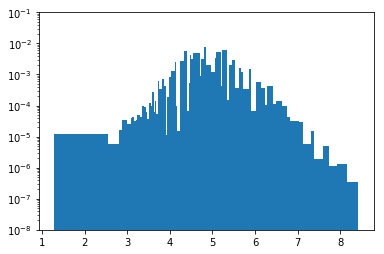

In [12]:
e = (a['log10(E/GeV)_max']) 

print(np.diff(np.unique(e)))
print(b.values.sum())

fig, ax = plt.subplots()
ax.hist(e.values, bins=np.unique(e)[::3], weights=b.values)
ax.set_ylim(1e-8, 1e-1)
ax.set_yscale('log')